<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/11_LSTM_recipe_generator_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.4 MB/s eta 0:00:00


In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
with open('/content/gdrive/My Drive/recipe_texts.pkl', 'rb') as f:
    recipe_texts = pickle.load(f)

In [5]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
vocab_size = AutoConfig.from_pretrained(model_ckpt).vocab_size

vocab_size

30522

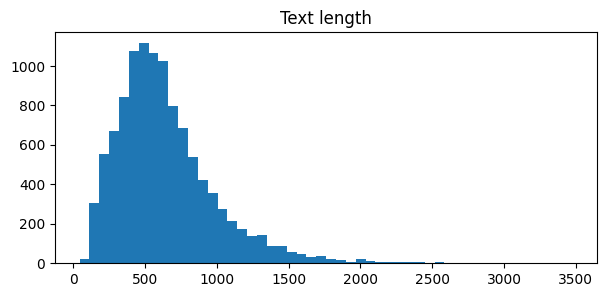

In [6]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

In [7]:
text_length = 512
train_set = tokenizer(recipe_texts, max_length=text_length,
                      padding='max_length', truncation=True)

train_text = np.array(train_set['input_ids'])[:,:-1]
train_label = np.array(train_set['input_ids'])[:,1:]

In [8]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Embedding(vocab_size, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM_cell'))
lstm_model.add(layers.Dense(vocab_size, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         batch_size=8, epochs=5)

Epoch 1/3
1364/1364 [==============================] - 374s 266ms/step - loss: 1.3590 - acc: 0.7819
Epoch 2/3
1364/1364 [==============================] - 321s 235ms/step - loss: 0.7485 - acc: 0.8484
Epoch 3/3
1364/1364 [==============================] - 319s 234ms/step - loss: 0.6546 - acc: 0.8601
CPU times: user 6min 41s, sys: 2min 45s, total: 9min 26s
Wall time: 17min 24s


In [13]:
lstm_model.save('/content/gdrive/My Drive/LSTM_recipe_generator.hd5', save_format='h5')

In [14]:
ls -lh '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'

-rw------- 1 root root 383M Jul  1 21:52 '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'
